In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf #needed for models in this script
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
pd.set_option('html', True) #see the dataframe in a more user friendly manner
%matplotlib inline

## Clustering Overview

Previously, we've looked at data where we did know what belonged to what. Our data was labeled, and we could learn off of those labels. For those data we could use supervised learning techniques. Often, data won't be neatly and nicely labeled.

There can be many attributes or features, but no label to indicate which rows belong to which label or group. Without the labels, we'd be hard-pressed to build a classification model. We wouldn't even know what values we're classifying things as!

One approach to this situation is to try to find some "natural" groupings in the data. Clustering is one such approach that looks at each of the different attributes in the data and tries to group the data based on rows that have similar values for the attributes.

## Data Cleaning and Exploration

One of the most common clustering techniques is K-Means Clustering. K-Means is an unsupervised learning technique, meaning that it is a technique for finding patterns in data without prior knowledge of what belongs to what. We have to go find the lables in the data.

The technique is in the name. The "means" refers to the fact that the technique works by computing the mean of some attributes. That mean represents the center of one cluster. "K" is the number of such clusters. The technique effectively computes K number of means and clusters the data around these K-Means.

To illustrate the algorithm, we're going to use the Iris dataset. This is just to illustrate what k-means will try to find in the data (clusters of similarity) and not unsupervised learning. With this dataset, we know what the labels are (species). But when we don't know what the labels are in advance, it is helpful to uncover the clusters that exist. We'll do this in the next assignment with data from the U.N.

In [3]:
#read in iris data:
iris_data = pd.read_csv('iris.data.txt', header=None, sep = ',')
iris_data.columns = ['sepal_len', 'sepal_width', 'petal_len', 'petal_width', 'class']
iris_data.head()

,sepal_len,sepal_width,petal_len,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<b>Plot different combinations of Iris Variables and how they relate to the class:</b>

In [4]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [5]:
def column_scatter(dataframe,column1,column2,class_column):
    
    #scatterplot:
    plt.figure(figsize=(10, 7))

    #data:
    features = dataframe[[column1, column2]]
    target = dataframe[class_column]

    # Get unique names of species
    uniq = list(set(target))

    # Set the color map to match the number of species
    z = range(1,len(uniq))
    hot = plt.get_cmap('hot')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    # Plot each species
    for i in range(len(uniq)):
        indx = target == uniq[i]
        plt.scatter(features.ix[:, 0][indx], features.ix[:, 1][indx], s=45 , color=scalarMap.to_rgba(i), label=uniq[i])
        #s=30; size of dots in the graph

    #set limits for the axis:
    x_min, x_max = features.ix[:, 0].min() - .25, features.ix[:, 0].max() + .25 #min/max for sepal length
    y_min, y_max = features.ix[:, 1].min() - .25, features.ix[:, 1].max() + .25 #min/max for sepal width

    #set labels:
    plt.xlabel(column1, fontsize = 12)
    plt.ylabel(column2, fontsize = 12)
    plt.title('Class based on ' + column1 + ' vs. ' + column2, fontsize=14)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.legend()
    plt.grid()
    plt.show

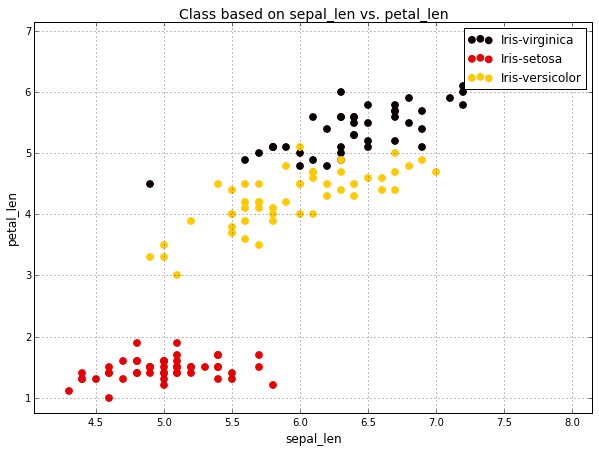

In [6]:
#Sepal length vs. Petal Length
column_scatter(iris_data,'sepal_len','petal_len','class')

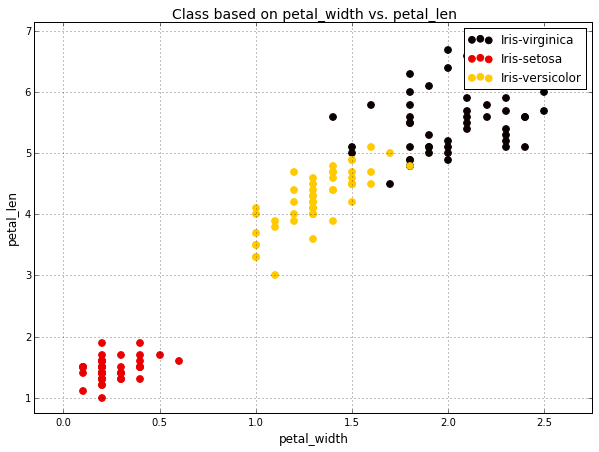

In [7]:
#Petal Width vs. Petal Length
column_scatter(iris_data,'petal_width','petal_len','class')

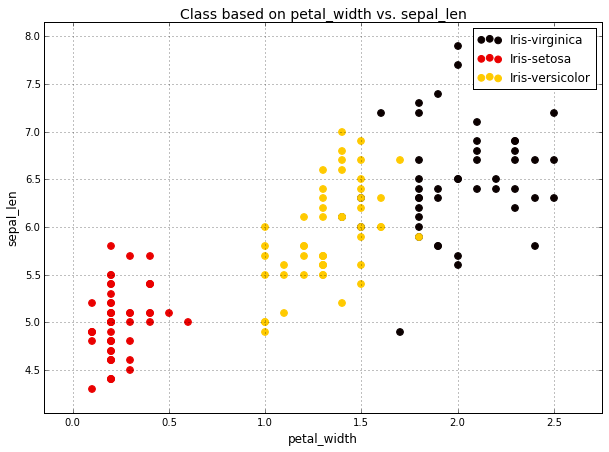

In [8]:
#Petal Width vs. Sepal Length
column_scatter(iris_data,'petal_width','sepal_len','class')

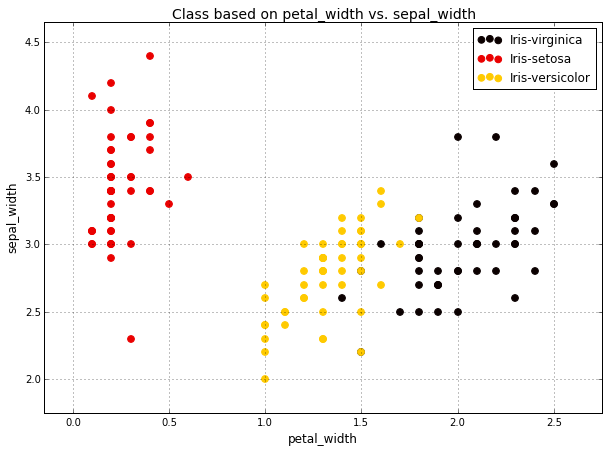

In [9]:
#Petal Width vs. Sepal Width
column_scatter(iris_data,'petal_width','sepal_width','class')

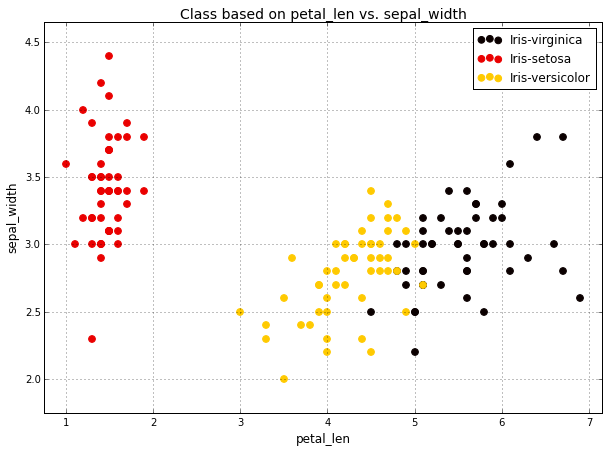

In [10]:
#Petal Length vs. Sepal Width
column_scatter(iris_data,'petal_len','sepal_width','class')

<b>Comment:</b> From the above graphs it would be quite easy for an algorithm to decide classes; the data has sufficient differentiation. 

## Cluster Analysis

Now we're going to apply K-Means clustering to a data set from the UN on economic and demographic data for different countries. We'll also use some well-known techniques to find the right K to use.

* Load the UN countries dataset from this link: (https://drive.google.com/file/d/0B7Vwt0JZZE6qSzIyckNiU0x3U3c/view)
* Determine how many rows are in the dataset. Determine the number of non-null values present in each column.
* Based on the number of non-null values, which columns do you think will be the best to try to cluster on?
* Determine the data type of each column.
* How many counries are present in the dataset?
* We're going to see how lifeMale, lifeFemale and infantMortality cluster according to GDPperCapita, keeping in mind that we don't know in advance how many clusters there will be.

In [12]:
#read data:
UN_frame = pd.read_csv('un.csv')
UN_frame.head()

,country,region,tfr,contraception,educationMale,educationFemale,lifeMale,lifeFemale,infantMortality,GDPperCapita,economicActivityMale,economicActivityFemale,illiteracyMale,illiteracyFemale
0,Afghanistan,Asia,6.90,NaN,NaN,NaN,45.0,46.0,154,2848,87.5,7.2,52.800,85.00
1,Albania,Europe,2.60,NaN,NaN,NaN,68.0,74.0,32,863,NaN,NaN,NaN,NaN
2,Algeria,Africa,3.81,52,11.1,9.9,67.5,70.3,44,1531,76.4,7.8,26.100,51.00
3,American.Samoa,Asia,NaN,NaN,NaN,NaN,68.0,73.0,11,NaN,58.8,42.4,0.264,0.36
4,Andorra,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print len(UN_frame)

207


In [14]:
UN_frame.isnull().sum()

country                     0
region                      0
tfr                        10
contraception              63
educationMale             131
educationFemale           131
lifeMale                   11
lifeFemale                 11
infantMortality             6
GDPperCapita               10
economicActivityMale       42
economicActivityFemale     42
illiteracyMale             47
illiteracyFemale           47
dtype: int64

In [15]:
UN_frame.dtypes

country                    object
region                     object
tfr                       float64
contraception             float64
educationMale             float64
educationFemale           float64
lifeMale                  float64
lifeFemale                float64
infantMortality           float64
GDPperCapita              float64
economicActivityMale      float64
economicActivityFemale    float64
illiteracyMale            float64
illiteracyFemale          float64
dtype: object

In [16]:
UN_frame.country.value_counts().size

207

We're going to see how:   
1) lifeMale,   
2) lifeFemale   
3) infantMortality cluster   
according to GDPperCapita, keeping in mind that we don't know in advance how many clusters there will be.

Before we cluster the dataset, we need to determine the ideal number of clusters. For this, we need numpy and scipy.

* We're going to explore 1 to 10 clusters. Define a range K from 1 to 10.
* Apply scipy.cluster.vq.kmeans 1 to 10 and determine the cluster centroids.
* Calculate the distance between each point and each cluster centroid.
* Determine the closest centroid for each point.
* Calculate the average within-cluster sum of squares for each centroid.

When we cluster, we are effectively trying to minimize the Euclidian distance between a cluster centroid and the points in that cluster. Practically, we define our clusters based on what will minimize what's called the within-cluster sum of squares (WCSS) (since sum of squares is the squared Euclidian distance).

Plot the number of clusters against the average within-cluster sum of squares. At what number of clusters does the curve seem to "level out"?

<b>Comment: Horrible instruction. The scipy.cluster.vq.kmeans should have an example walk-through with an explanation. I'm totally in the dark. I'm moving on from this part until our session.</b>

<b>My code for scipy.cluster.vq.kmeans:</b>